# Import packages

In [1]:
import numpy as np
from numpy import array
from pickle import dump
import os
import zipfile

# pandas is a data analysis tool, contains object DataFrame
import pandas as pd
#import torch
#
import random

# regex
import re

# datetime objects
import datetime

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# used for creating the dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# used for flattening lists 
from itertools import chain
from itertools import compress

# NLTK and WordNet lemmatizer
import nltk
from nltk.stem import WordNetLemmatizer



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
import numpy
import itertools
import json
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.layers import Input, Dense, LSTM, Flatten, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
import numpy as np 
import numpy as np
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from itertools import repeat
from keras.callbacks import Callback
 

# Training Data

In [2]:
train_data= pd.read_pickle("C:\\Users\\A373503\\Desktop\\Complete_4_models\\HDFS\\Data\\HDFS_train_normal_data.pkl")
word2id=pd.read_pickle('C:\\Users\\A373503\\Desktop\\Complete_4_models\\HDFS\\Data\\word2id_train_normal.pkl')

In [3]:
word2id["unknown"]=len(word2id)+1

In [4]:
print("the size of the data:",len(train_data))
print("the size of the vocab:",len(word2id))
train_data.groupby(['labels']).count()

the size of the data: 446541
the size of the vocab: 52


,Blockid,EventSequence,Length
labels,,,
0,446541,446541,446541


In [5]:
train_data.head()

,Blockid,EventSequence,labels,Length
569963,blk_-8263499994297877702,"[2, 2, 2, 12, 3, 4, 3, 4, 3, 4, 5, 5, 5, 6, 6,...",0,19
486412,blk_6623683650071326961,"[2, 11, 2, 2, 3, 4, 3, 4, 3, 4, 5, 5, 14]",0,13
171779,blk_2082025639925650040,"[2, 2, 2, 12, 3, 4, 3, 4, 3, 4, 5, 5, 5, 9, 10...",0,25
224584,blk_5448888175997650632,"[2, 2, 11, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 6, 6,...",0,19
536913,blk_4492763112427066795,"[2, 2, 11, 2, 3, 4, 3, 4, 3, 4, 5, 5, 14]",0,13


# Test data

In [6]:
test_data=pd.read_pickle("C:\\Users\\A373503\\Desktop\\Complete_4_models\\HDFS\\Data\\HDFS_test_data.pkl")
test_data.head()

,Blockid,Preprocess_to_log_lines,labels,Length
130892,blk_-7677011170870236960,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,23
174562,blk_6638067388838485468,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,25
45990,blk_-2587859430834379342,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,20
192504,blk_7519767082407935685,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,19
43736,blk_-2548681213192465965,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,19


In [7]:
print("the size of the data:",len(test_data))
test_data.groupby(['labels']).count()

the size of the data: 115013


,Blockid,Preprocess_to_log_lines,Length
labels,,,
0,111682,111682,111682
1,3331,3331,3331


In [8]:
print("The size of training data:",len(train_data))
print("The size of test data:",len(test_data))

The size of training data: 446541
The size of test data: 115013


<b> To avoid ignoring the short lengths logs: to do the same as volvo data, only padding on test data

In [9]:
def padding_short_logs(data,window_size):
    for i in range(len(data)):
        if len(data.EventSequence.iloc[i]) < window_size+1:
            data.EventSequence.iloc[i]=pad_sequences([data.EventSequence.iloc[i]], maxlen=window_size+1)[0]
            #print(data.EventSequence.iloc[i])

In [42]:
data=train_data
window_size=11
w_s=10
padding_short_logs(data,window_size)

In [11]:
train_data[train_data["Length"] < window_size]

,Blockid,EventSequence,labels,Length


# Creating the input and target

In [28]:
volab=len(word2id)
def generate_for_bilstm(data, self_defined_size,step):
    x_left = []
    x_right= []
    x=[]
    y = []
    seq=[]
    for i in range(len(data)):
        for item in range(0,len(data["EventSequence"].iloc[i])-self_defined_size+1,step):
            seq=data.EventSequence.iloc[i]
            sentence=seq[item:item+self_defined_size]
            left_inputs=sentence[:5]
            right_inputs=sentence[6:][::-1]
            target=sentence[5]
            #target=seq[item+window_size]
            x.append(sentence)    
            x_left.append(left_inputs)
            x_right.append(right_inputs)
            y.append(target)
            
    x= np.array(x)      
    x_left=np.array(x_left)
    x_right=np.array(x_right)
    #y=np.array(y)
    y=to_categorical(y, volab+1)

    return x_left, x_right,y,x

In [29]:
list(train_data[:1].EventSequence)

[[2, 2, 2, 12, 3, 4, 3, 4, 3, 4, 5, 5, 5, 6, 6, 6, 7, 7, 8]]

In [36]:
x_left_n, x_right_n,y_n,x_n=generate_for_bilstm(train_data[:1], 11,1)

In [37]:
x_n

array([[ 2,  2,  2, 12,  3,  4,  3,  4,  3,  4,  5],
       [ 2,  2, 12,  3,  4,  3,  4,  3,  4,  5,  5],
       [ 2, 12,  3,  4,  3,  4,  3,  4,  5,  5,  5],
       [12,  3,  4,  3,  4,  3,  4,  5,  5,  5,  6],
       [ 3,  4,  3,  4,  3,  4,  5,  5,  5,  6,  6],
       [ 4,  3,  4,  3,  4,  5,  5,  5,  6,  6,  6],
       [ 3,  4,  3,  4,  5,  5,  5,  6,  6,  6,  7],
       [ 4,  3,  4,  5,  5,  5,  6,  6,  6,  7,  7],
       [ 3,  4,  5,  5,  5,  6,  6,  6,  7,  7,  8]])

In [32]:
x_left, x_right,y,x=generate_for_bilstm(train_data, 11,1)

In [33]:
x

array([[ 2,  2,  2, ...,  3,  4,  5],
       [ 2,  2, 12, ...,  4,  5,  5],
       [ 2, 12,  3, ...,  5,  5,  5],
       ...,
       [ 2,  2, 12, ...,  3,  4,  5],
       [ 2, 12,  2, ...,  4,  5,  5],
       [12,  2,  3, ...,  5,  5, 14]])

In [34]:
len(x_left) #3794935

4241476

In [35]:
print("The first big window is:",x[0])
print("The first left input is:",x_left[0])
print("The first right input is:",x_right[0])
print("The first target is:",y[0])

The first big window is: [ 2  2  2 12  3  4  3  4  3  4  5]
The first left input is: [ 2  2  2 12  3]
The first right input is: [5 4 3 4 3]
The first target is: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


# Fix the testdata: 
<b>transform the logs into integers as the same in the vocab and if unknown logs are found, transfer those into 0.

In [38]:
test_data.head()

,Blockid,Preprocess_to_log_lines,labels,Length
130892,blk_-7677011170870236960,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,23
174562,blk_6638067388838485468,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,25
45990,blk_-2587859430834379342,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,20
192504,blk_7519767082407935685,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,19
43736,blk_-2548681213192465965,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,19


In [39]:
test_data[test_data['Length']<window_size]

,Blockid,Preprocess_to_log_lines,labels,Length
224054,blk_-5426282504664657154,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2
320419,blk_1815563099310760915,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2
319055,blk_-6624920247738861943,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2
120040,blk_-5057408869195318440,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,2
59945,blk_-5648641265825038822,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4
...,...,...,...,...
104248,blk_-1505433512692687124,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4
496903,blk_4614053612572819297,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2
61365,blk_3907620519002497721,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4
72506,blk_4935208783324374013,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4


In [40]:
inx=()
forj=[]
ends=[]
for i in range(len(test_data)):

    lists=test_data.Preprocess_to_log_lines.iloc[i]

    for j in range(len(lists)):
        
        char=test_data.Preprocess_to_log_lines.iloc[i][j]
        if char in word2id:
            inx = word2id[char]
        else:
            inx = 52
            
        forj += [inx]
        
    ends+=[forj]
    forj= []

In [41]:
test_data['EventSequence']=ends

In [20]:
test_data.head()

,Blockid,Preprocess_to_log_lines,labels,Length,EventSequence
130892,blk_-7677011170870236960,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,23,"[11, 2, 2, 2, 5, 5, 5, 3, 4, 3, 4, 3, 4, 10, 1..."
174562,blk_6638067388838485468,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,25,"[2, 12, 2, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 10, 9..."
45990,blk_-2587859430834379342,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,20,"[15, 2, 2, 2, 5, 5, 5, 3, 4, 3, 4, 3, 4, 13, 6..."
192504,blk_7519767082407935685,[_info_dfs_datanode_dataxceiver_receiving_bloc...,0,19,"[2, 2, 2, 15, 3, 4, 3, 4, 3, 4, 5, 5, 5, 6, 6,..."
43736,blk_-2548681213192465965,[_info_dfs_fsnamesystem_block_namesystem_alloc...,0,19,"[15, 2, 2, 2, 5, 5, 5, 3, 4, 3, 4, 3, 4, 6, 6,..."


In [43]:
padding_short_logs(test_data,w_s)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
test_data[test_data["Length"] < window_size]

,Blockid,Preprocess_to_log_lines,labels,Length,EventSequence
224054,blk_-5426282504664657154,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 29]"
320419,blk_1815563099310760915,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 29]"
319055,blk_-6624920247738861943,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 29]"
120040,blk_-5057408869195318440,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 52]"
59945,blk_-5648641265825038822,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4,"[0, 0, 0, 0, 0, 0, 0, 15, 2, 2, 52]"
...,...,...,...,...,...
104248,blk_-1505433512692687124,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4,"[0, 0, 0, 0, 0, 0, 0, 12, 2, 2, 52]"
496903,blk_4614053612572819297,[_info_dfs_datanode_dataxceiver_receiving_bloc...,1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 29]"
61365,blk_3907620519002497721,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4,"[0, 0, 0, 0, 0, 0, 0, 15, 2, 2, 52]"
72506,blk_4935208783324374013,[_info_dfs_fsnamesystem_block_namesystem_alloc...,1,4,"[0, 0, 0, 0, 0, 0, 0, 12, 2, 2, 52]"


In [45]:
x_left_test, x_right_test,y_test,x_test=generate_for_bilstm(test_data, window_size,1)

In [46]:
len(x_left_test)

1097462

# model 

In [47]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.optimizers import Adagrad

first_input = Input(shape=(5, ))
first_embedding = Embedding(len(word2id)+1,128)(first_input)
first_lstm = LSTM(64)(first_embedding)
#first_lstm = 

second_input = Input(shape=(5, ))
second_embedding = Embedding(len(word2id)+1,128)(second_input)
second_lstm = LSTM(64)(second_embedding)
#second_lstm


merge_one = concatenate([first_lstm, second_lstm])
relu = Dense(128, activation='relu')(merge_one)
softmax = Dense(len(word2id)+1, activation='softmax')(relu)
model = Model(inputs=[first_input, second_input], outputs=softmax)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 128)       6784        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 128)       6784        input_2[0][0]                    
______________________________________________________________________________________________

<b>validation_split</b>: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch

In [48]:
optim=tf.keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,
           patience=5, verbose=1)
logs = Callback()
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
model.fit([x_left,x_right], y, batch_size=64, epochs=10,shuffle = True,validation_split = 0.1, callbacks=[reduce_lr])

Epoch 1/10
59646/59646 [==============================] - 396s 7ms/step - loss: 0.0802 - accuracy: 0.9766 - recall: 0.9713 - precision: 0.9824 - true_positives: 1873248.6344 - true_negatives: 99241933.5370 - false_positives: 26061.2348 - false_negatives: 35487.3640 - val_loss: 0.0358 - val_accuracy: 0.9887 - val_recall: 0.9879 - val_precision: 0.9896 - val_true_positives: 419019.0000 - val_true_negatives: 22051508.0000 - val_false_positives: 4403.0000 - val_false_negatives: 5129.0000
Epoch 2/10
59646/59646 [==============================] - 383s 6ms/step - loss: 0.0356 - accuracy: 0.9888 - recall: 0.9882 - precision: 0.9896 - true_positives: 1886186.4494 - true_negatives: 99247589.1607 - false_positives: 19752.7301 - false_negatives: 22549.5490 - val_loss: 0.0343 - val_accuracy: 0.9891 - val_recall: 0.9886 - val_precision: 0.9899 - val_true_positives: 419312.0000 - val_true_negatives: 22051604.0000 - val_false_positives: 4289.0000 - val_false_negatives: 4836.0000
Epoch 3/10
59646/59646

In [49]:
# Save model
model.save('hdfs_05_05_bilstm_normal_train.txt')

# load model
model = load_model('hdfs_05_05_bilstm_normal_train.txt')

INFO:tensorflow:Assets written to: hdfs_05_05_bilstm_normal_train.txt\assets


INFO:tensorflow:Assets written to: hdfs_05_05_bilstm_normal_train.txt\assets


# softmax output

In [50]:
#softmax output
prediction = model.predict([x_left_test,x_right_test], verbose=1)

34296/34296 [==============================] - 43s 1ms/step


In [51]:
len(prediction)

1097462

# Point the target to the corresponding block

In [52]:
len(test_data)

115013

In [77]:
def labeled_targets(data,window_size):
    window_num=[]
    for i in range(len(data)):        
        window_n=len(data.EventSequence.iloc[i])-window_size+1
        window_num.append(window_n)        
    return window_num

In [78]:
window_num=labeled_targets(test_data,window_size)

In [79]:
#check the functions are correct
print("sum of the window_num",sum(window_num))
print("window num of X_test",len(x_left_test))

##################################33
#if the two values are same: no error step now

sum of the window_num 1097462
window num of X_test 1097462


In [66]:
for i in window_num:
    if i<1:
        print(i)
#make sure we do not have any negetive numbers
#if we have the negetive number: we did not padding the short length logs

#  Deeplog Method : 

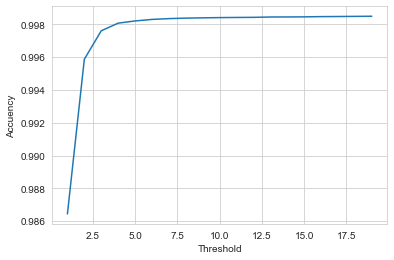

In [67]:
#find the best threshold
accs=list()

for i in range(1,20):
    preds=(-prediction).argsort()[:,:i]
    truth=(-y_test).argsort()[:,0]
    truth=truth[:, None]
    
    acc=sum([truth[i] in preds[i] for i in range(len(truth))])/len(truth)  
    accs.append(acc)
    
x=np.arange(1,20)
plt.xlabel('Threshold')
plt.ylabel('Accuency')
plt.plot(x,accs)
       

In [80]:
window_num.append(-1) #solve the first number issue

In [90]:
import time
start_time = time.time()


TN=0 #ture negative
FP=0 #false positive
FN=0 #false negative
TP=0 #ture positive
precision=0
recall=0
accuracy=0
f1_score=0
left=0
right=0

n=10

preds=(-prediction).argsort()[:,:n]
truth=(-y_test).argsort()[:,0]
truth=truth[:, None]


for i in range(len(test_data)): #for each blocks

    num_preds=window_num[i] #we have how many targets(prediction)

    #print(num_preds, "predicts in the",i+1,"th block " )
    #print("In this block, the lable should be",test_data_small.Labels.iloc[i])   
    window_num[-1]=-1
    left+=window_num[i-1]
    right+=window_num[i]
       
    if int(sum([truth[j] in preds[j] for j in range(left+1,right)])/window_num[i]) is not 1: # anomaly prediction
        if int(test_data.labels.iloc[i]) == 1: #label is anomaly
            
            TP+=1
        else: #label is normal
            FP+=1
            
    if int(sum([truth[j] in preds[j] for j in range(left+1,right)])/window_num[i]) is 1: #normal prediction
        if int(test_data.labels.iloc[i]) == 0: #label is normal
            TN+=1
        else: #label is anomaly
            FN+=1
            
            

    #here is to check all things are correct!!
    #print(window_num[i],left+1,right)
    if i == len(test_data)-1: 
        print("This print is to check all ranges are correct:")
        print("The range will be in",left+1,'and',right,"and the lenth of the targets in this block is",window_num[i])
        print(" Round",i+1," done!!!\n")

    

                 
        

print("Top",n,":")
#print("We have",len(test_data),"blocks in total.")
#print("We have",len(y_test),"windows in total.")
print("True positive (anomaly with anomaly prediction):",TP)
print("False negative (normal with anomaly prediction):",FP)
print("False positive (anomaly with normal prediction): ",FN)
print("True negative (normal with normal prediction):",TN)
            
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
f1_score=(2*recall*precision)/(recall+precision)

print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1_score)
print("---The runing time is: %s seconds ---" % (time.time() - start_time))         


This print is to check all ranges are correct:
The range will be in 1097453 and 1097462 and the lenth of the targets in this block is 9
 Round 115013  done!!!

Top 10 :
True positive (anomaly with anomaly prediction): 1526
False negative (normal with anomaly prediction): 21
False positive (anomaly with normal prediction):  1805
True negative (normal with normal prediction): 111661
Accuracy: 0.9841235338613896
Precision: 0.9864253393665159
Recall: 0.4581206844791354
F1 score: 0.6256662566625666
---The runing time is: 11.194953680038452 seconds ---
